In [1]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
import itertools
from math import prod

from skimage.transform import resize
from skimage.color import rgb2gray

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from torch.utils.data import Dataset
import torchvision.transforms as transforms

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#change runtime type to GPU
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [4]:
real_waldo = rgb2gray(resize(plt.imread("drive/MyDrive/PyTorch/waldo.png"), (8, 8))[:, :, 0:3])

In [5]:
class WaldoDataset(Dataset):
  def __init__(self, waldo, samples=100, h=28, w=28, transforms=None):
    self.N = samples
    self.waldo_h, self.waldo_w = waldo.shape
    self.h, self.w = h, w
    self.transforms = transforms

    self.indices = np.random.randint(0, self.h-self.waldo_h, size=(self.N, 2))

    self.waldo = waldo

  def __len__(self):
    return self.N

  def __getitem__(self, index):

    x, y = self.indices[index]

    np.random.seed(index)
    area = np.random.rand(self.h, self.w).astype(np.float32)

    area[x:x+self.waldo_h, y:y+self.waldo_w] = self.waldo

    if self.transforms:
      area = self.transforms(area)

    return (area, torch.Tensor(self.indices[index].astype(np.float32)))


In [6]:
waldo_dataset = WaldoDataset(real_waldo, samples = 10_000, h=100, w=100, transforms=transforms.ToTensor())

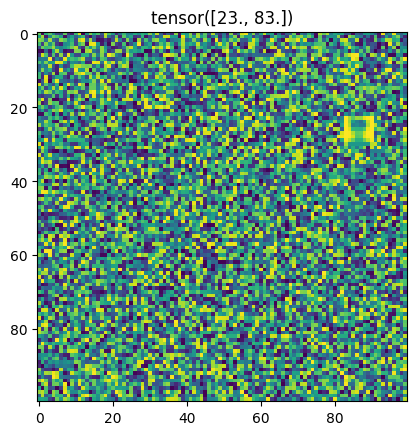

In [7]:
ind = 10
plt.imshow(waldo_dataset[ind][0].reshape(100, 100))
plt.title(str(waldo_dataset[ind][1]))
plt.show()

In [8]:
split = int(len(waldo_dataset)*.8)
waldo_train, waldo_test = torch.utils.data.random_split(waldo_dataset, [split, len(waldo_dataset)-split])

In [9]:
len(waldo_train), len(waldo_test)

(8000, 2000)

In [10]:
#model

#[1C x 28 x 28] -> conv2d[8 x 28 x 28] -> relu -> maxpool2d[8 x 14 x 14] -> batchnorm -> flatten[8*14*14] -> linear[256] -> linear[2] -> softmax

class WaldoNet(nn.Module):
  
  def __init__(self, h, w):
    super().__init__()
    self.h, self.w  = h, w
    self.conv = nn.Conv2d(1, 8, kernel_size=3, padding=1)
    self.batchnorm = nn.BatchNorm2d(8)
    in_fc1 = 8*self.h//2*self.w//2
    self.fc1 = nn.Linear(in_fc1, in_fc1//4)
    self.fc2 = nn.Linear(in_fc1//4, 2)

  def forward(self, x):
    out = self.conv(x)
    out = F.max_pool2d(torch.relu(out), 2)

    out = self.batchnorm(out)

    out = out.view(-1, 8 * self.h//2 * self.w//2)
    out = torch.relu(self.fc1(out))
    out = self.fc2(out)

    return out



In [11]:
#training loop
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, debug=True):
  loss_hist = []
  for epoch in range(1, n_epochs + 1):
    loss_train = 0.0
    for imgs, labels in train_loader:
      imgs = imgs.to(device=device) #send to current device
      labels = labels.to(device=device)


      optimizer.zero_grad()

      outputs = model(imgs)
      loss = loss_fn(outputs, labels)
      loss.backward()
      optimizer.step()
      
      loss_train += loss.item()

    train_loss = loss_train / len(train_loader)
    loss_hist += [train_loss]
    
    if debug and epoch%(epochs//10) == 0:
      print(f"Epoch {epoch}, Training loss {round(train_loss, 10)}")

  
  return loss_hist

In [12]:
model = WaldoNet(h=100, w=100).to(device=device)

epochs = 20
learning_rate = 0.01
optimizer = optim.Adam(model.parameters(), 
                       lr=learning_rate)

loss_fn = nn.MSELoss()

train_loader = torch.utils.data.DataLoader(waldo_train, batch_size=256,shuffle=True)

train_model_out = training_loop(
  n_epochs = epochs,
  optimizer = optimizer,
  model = model,
  loss_fn = loss_fn,
  train_loader = train_loader,
)

Epoch 2, Training loss 633.1976909637
Epoch 4, Training loss 1161.9284906387
Epoch 6, Training loss 298.3875207901
Epoch 8, Training loss 134.5476198196
Epoch 10, Training loss 51.4490791559
Epoch 12, Training loss 26.3433493376
Epoch 14, Training loss 20.8563586473
Epoch 16, Training loss 14.1952068806
Epoch 18, Training loss 10.3755120039
Epoch 20, Training loss 10.4632213712


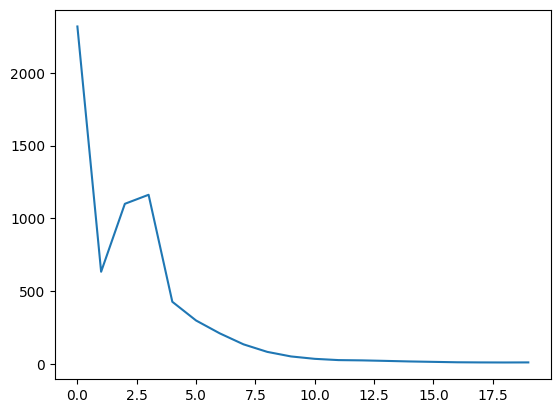

In [13]:
plt.plot(train_model_out)

Text(0.5, 1.0, 'Pred: [[87.40205  23.181095]], Real: [88. 20.]')

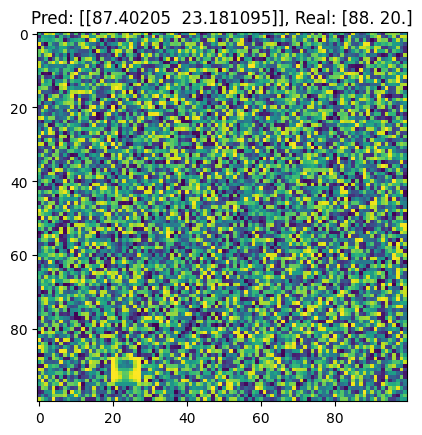

In [14]:
ind = 0
pred = model(waldo_train[ind][0].reshape(1, 1, 100, 100).to(device=device)).detach().cpu().numpy()

plt.imshow(waldo_train[ind][0].reshape(100, 100))
plt.title(f"Pred: {pred}, Real: {waldo_train[ind][1].detach().numpy()}")